In [1]:
import sys
import numpy as np

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import pickle
from importlib import reload
import numpy as np

In [3]:
# Load state sequence and data from the pickle file
with open('/Users/david/Documents/mastersCode/ubm/final/tests/train-test-val.pkl', 'rb') as file:
    loaded_train_test_val = pickle.load(file)

# Access the loaded data
# loaded_ss = loaded_data['state_sequence']
# loaded_data = loaded_data['data']

In [4]:
from final.useful import *

In [5]:
nfft = 128 # 32
labels = np.unique(loaded_train_test_val['train'].sample_labels)
# get_log_power_feature()

In [6]:
train_labels = loaded_train_test_val['train'].sample_labels
train_samples = loaded_train_test_val['train'].samples
humpback_indices = train_labels == 0
train_samples_humpback = [item for item, condition in zip(train_samples, humpback_indices) if condition]


In [7]:
def get_feature(sample, nfft):
    feat = np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))
    return feat

In [8]:
train_features_humpback = []
for sample in train_samples_humpback:
    train_features_humpback.append(get_feature(sample, nfft))

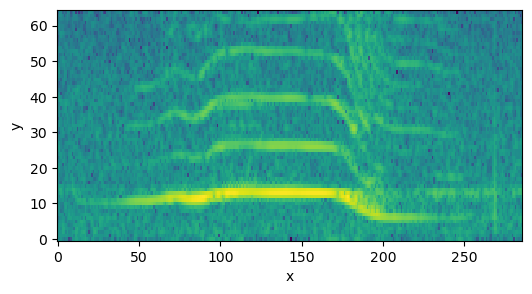

In [9]:
vis_helper(train_features_humpback[0])

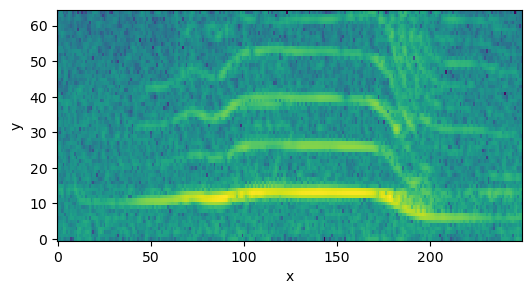

In [10]:
train_features_humpback_concat = np.concatenate(train_features_humpback)
smaller_features = train_features_humpback_concat[:250,:]
np.min(smaller_features)
vis_helper(smaller_features)

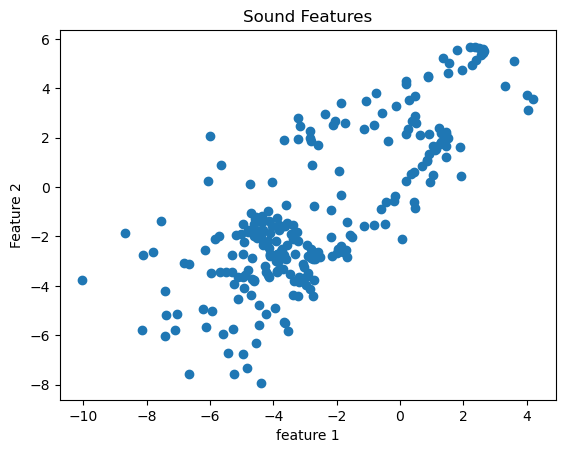

7.0750375

In [11]:
plt.scatter(smaller_features[:, 10], smaller_features[:, 11])
plt.title('Sound Features')
plt.xlabel('feature 1')
plt.ylabel('Feature 2')
plt.show()
np.var(smaller_features)

In [42]:
import final.models.hdphmm.hdphmmwl.hdphmmwl as hdphmm
from final.models.hdphmm.helpers.plot_hmm import plot_hmm_data
import final.models.hdphmm.hdphmmwl.consts as const
import final.models.hdphmm.hdphmmwl.numba_wl as numba
reload(const)
reload(numba)
reload(hdphmm)

sbp = {
    const.ALPHA0: 50,
    const.GAMMA0: 10,
    const.KAPPA0: 5,
}
sbp[const.RHO0] = sbp[const.KAPPA0] / ( sbp[const.KAPPA0] + sbp[const.ALPHA0])
temp = 1
hdp_hmm = hdphmm.HDPHMMWL(smaller_features, 30, iterations=50, sbp=sbp)

sbp given


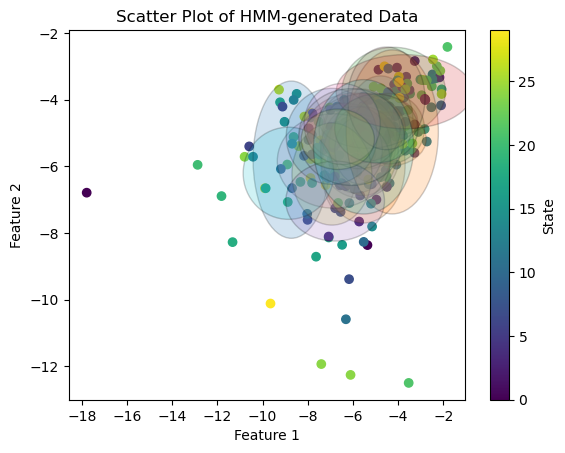

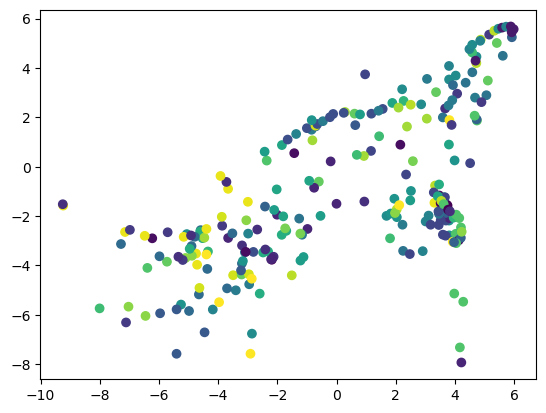

In [43]:
plot_hmm_data(smaller_features, hdp_hmm.Z, hdp_hmm.K, hdp_hmm.mu, hdp_hmm.sigma)
plt.scatter(smaller_features[:, 12], smaller_features[:, 11], c=hdp_hmm.Z, cmap='viridis', marker='o')

In [44]:
hdp_hmm.fit()

# plt.plot(range(0,len(hdp_hmm.trace[const.TIME])), hdp_hmm.trace[const.TIME], marker="None")
# plt.xlabel('iteration')
# plt.ylabel('ARI')
# plt.xlim(0,1)
# #plt.savefig("./image/ari.png")
# plt.show()
# plt.close()

print('average time for one gibbs sweep: ', np.mean(hdp_hmm.trace[const.TIME]))

fitting using gibbs sampling
average time for one gibbs sweep:  0.16863823413848877


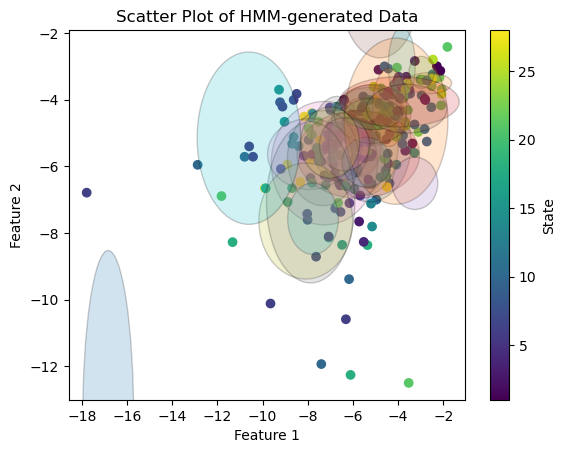

In [45]:
plot_hmm_data(smaller_features, hdp_hmm.Z, hdp_hmm.K, hdp_hmm.mu, hdp_hmm.sigma)

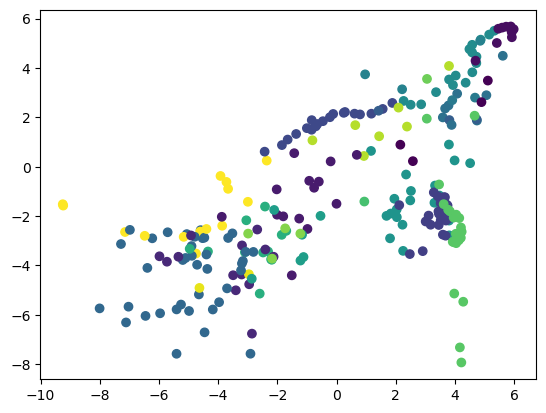

In [46]:
plt.scatter(smaller_features[:, 12], smaller_features[:, 11], c=hdp_hmm.Z, cmap='viridis', marker='o')